In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers.utils import *
from helpers.ops import *
from helpers.statistic import Statistic

### pixelRNN using diagonal biLSTM

In [2]:
class PixelRNN:
    def __init__(self, sess, height, width, channel, hidden_dim, grad_clip, model):
        self.sess = sess
        self.height = height
        self.width = width
        self.channel = channel
        self.hidden_dim = hidden_dim
        self.grad_clip = grad_clip
        self.model = model
        
        self.inputs = tf.placeholder(tf.float32, [None, height, width, channel]) 
        
        #--- [None, height, width, channel]
        #--- input_shape

        output = conv2dRNN(self.inputs, self.channel, hidden_dim, 7, 'a', 'input_conv')

        if self.model == 'pixel_rnn':
            lstm1_output = diagonal_bilstm(output, hidden_dim, hidden_dim, 'LSTM1')
            lstm2_output = diagonal_bilstm(lstm1_output, hidden_dim, hidden_dim, 'LSTM2')
            output = lstm2_output
        elif self.model == 'pixel_cnn':
            #Done Above
            pass

        output = conv2dRNN(output, hidden_dim, hidden_dim, 1, 'b', 'output_conv1', he_init=True)
        output = tf.nn.relu(output)
        
        output = conv2dRNN(output, hidden_dim, hidden_dim, 1, 'b', 'output_conv2', he_init=True)
        output = tf.nn.relu(output)

        logits = conv2dRNN(output, hidden_dim, 1, 1, 'b', 'output_conv3')
        self.output = tf.nn.sigmoid(logits)

        #self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        #    logits=logits, labels=self.inputs, name='loss'))
        #self.loss = tf.reduce_mean(tf.contrib.keras.metrics.binary_crossentropy(self.inputs, self.output))
        self.loss = tf.reduce_mean(-(tf.multiply(self.inputs, tf.log(self.output)) + tf.multiply(1-self.inputs, tf.log(1-self.output))))

        optimizer = tf.train.RMSPropOptimizer(1e-3)
        #optimizer = tf.train.AdamOptimizer(1e-3)
        self.grads_and_vars = optimizer.compute_gradients(self.loss)

        self.new_grads_and_vars = \
            [(tf.clip_by_value(gv[0], -self.grad_clip, self.grad_clip), gv[1]) for gv in self.grads_and_vars]
        self.optim = optimizer.apply_gradients(self.new_grads_and_vars)

        show_all_variables()
        
    def predict(self, images):
        return self.sess.run(self.output, {self.inputs: images})

    def generate(self):
        samples = np.zeros((100, self.height, self.width, 1), dtype='float32')
        for i in range(self.height):
            for j in range(self.width):
                for k in range(self.channel):
                    next_sample = binarize(self.predict(samples))
                    samples[:, i, j, k] = next_sample[:, i, j, k]
        return samples

### Image generation using pixel RNN

Extracting ../MNIST_data\train-images-idx3-ubyte.gz
Extracting ../MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data\t10k-labels-idx1-ubyte.gz
input_conv_inputs: (?, 28, 28, 1)
input_conv_outputs: (?, 28, 28, 64)
input_conv_outputs1: (?, 28, 28, 64)
64
28
output_state_fw_skewed_inputs: (?, 28, 55, 64)
i_to_s_inputs: (?, 28, 55, 64)
i_to_s_outputs: (?, 28, 55, 256)
i_to_s_outputs1: (?, 28, 55, 256)
output_state_fw input_to_state: (?, 28, 55, 256)
output_state_fw rnn_inputs: [None, 55, 28, 256]
output_state_fw rnn_inputs1: (?, 55, 7168)
DiagonalBiLSTMCell_conv_s_to_s: (?, 28, 1, 256)
DiagonalBiLSTMCell_i_to_s: (?, 7168)
DiagonalBiLSTMCell_s_to_s: (?, 7168)
DiagonalBiLSTMCell_o: (?, 1792)
DiagonalBiLSTMCell_f: (?, 1792)
DiagonalBiLSTMCell_i: (?, 1792)
DiagonalBiLSTMCell_g: (?, 1792)
diagonal_lstm_dynamic_rnn: (?, 55, 1792)
diagonal_lstm_outputs0: (?, 28, 55, 64)
diagonal_lstm_outputs3: (?, 28, 28, 64)
64
28
output_state_bw_ske

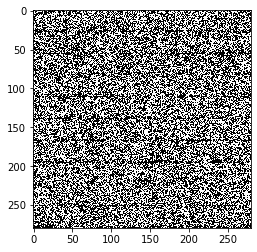

Epoch: 0, iteration:1, train loss: 0.730594, test loss: 0.728666
Epoch: 0, iteration:2, train loss: 0.730440, test loss: 0.724611
Epoch: 0, iteration:3, train loss: 0.726193, test loss: 0.723979
Epoch: 0, iteration:4, train loss: 0.727827, test loss: 0.727672
Epoch: 0, iteration:5, train loss: 0.724378, test loss: 0.727190
Epoch: 0, iteration:6, train loss: 0.725811, test loss: 0.719422
Epoch: 0, iteration:7, train loss: 0.719448, test loss: 0.725853
Epoch: 0, iteration:8, train loss: 0.727747, test loss: 0.721392
Epoch: 0, iteration:9, train loss: 0.724765, test loss: 0.718475
Epoch: 0, iteration:10, train loss: 0.719973, test loss: 0.721719
Epoch: 0, iteration:11, train loss: 0.718742, test loss: 0.719073
Epoch: 0, iteration:12, train loss: 0.721279, test loss: 0.717483
Epoch: 0, iteration:13, train loss: 0.720155, test loss: 0.718029
Epoch: 0, iteration:14, train loss: 0.718992, test loss: 0.719872
Epoch: 0, iteration:15, train loss: 0.714677, test loss: 0.713255
Epoch: 0, iteration

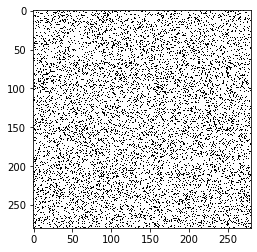

Epoch: 0, iteration:101, train loss: 0.405270, test loss: 0.391730
Epoch: 0, iteration:102, train loss: 0.400144, test loss: 0.404270
Epoch: 0, iteration:103, train loss: 0.407239, test loss: 0.398804
Epoch: 0, iteration:104, train loss: 0.390947, test loss: 0.392652


In [ ]:
%%time
import logging
logging.basicConfig(format="[%(asctime)s] %(message)s", datefmt="%m-%d %H:%M:%S")

flags = tf.app.flags

out_dir = './pixelRNN'
check_and_create_dir(out_dir)
batch_size = 100
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
# mnist = tf.keras.datasets.mnist
# (x_train, y_train),(x_test, y_test) = mnist.load_data()
train_step_per_epoch = mnist.train.num_examples / batch_size

height, width, channel = 28, 28, 1

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_conf.gpu_options.allow_growth = True
    sess = tf.Session(config=session_conf) 
    with sess.as_default(), tf.device('/gpu:0'):
        pixel_rnn = PixelRNN(sess, 28, 28, 1, 64, 1., 'pixel_rnn')
        sess.run(tf.global_variables_initializer())
        
        #---- run for 20 epochs
        for epoch in range(20):
            total_train_costs = []
            for idx in range(int(train_step_per_epoch)):
                x_mb, _ = mnist.train.next_batch(batch_size)
                x_mb = x_mb.reshape([batch_size, height, width, channel])
                x_mb = (np.random.uniform(size=x_mb.shape) < x_mb).astype('float32')
                _, cost, outputs = sess.run([pixel_rnn.optim, pixel_rnn.loss, pixel_rnn.output], feed_dict={pixel_rnn.inputs:x_mb})
                total_train_costs.append(cost)
                test_mb, _ = mnist.test.next_batch(batch_size)
                test_mb = test_mb.reshape([batch_size, height, width, channel])
                test_mb = (np.random.uniform(size=test_mb.shape) < test_mb).astype('float32')
                test_cost = sess.run(pixel_rnn.loss, feed_dict={pixel_rnn.inputs:test_mb})
                print("Epoch: %d, iteration:%d, train loss: %f, test loss: %f" % (epoch, idx, cost, test_cost))
                
                if idx % 100 == 0:
                    avg_train_cost = np.mean(total_train_costs)
                    #print("Epoch: %d, iteration:%d, train l: %f" % (epoch, idx, cost))
                    #print("Epoch: %d, iteration:%d, train l: %f" % (epoch, idx, avg_train_cost))
                    samples = pixel_rnn.generate()
                    save_images(samples, height, width, 10, 10, directory=out_dir, prefix='test_')
            avg_train_cost = np.mean(total_train_costs)
            samples = pixel_rnn.generate()
            save_images(samples, height, width, 10, 10, directory=out_dir, prefix='test_')
            print("Epoch: %d, iteration:%d, train l: %f" % (epoch, idx, avg_train_cost))
    print('!!!! ----- Execution completed ----- !!!!!')
    sess.close()